<a href="https://colab.research.google.com/github/Lukehsu1999/GE2340-Formality-Transfer/blob/main/BERT_Formality_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Installation</h1>

In [1]:
!pip install -q transformers

     |████████████████████████████████| 1.4MB 8.6MB/s 
     |████████████████████████████████| 2.9MB 17.0MB/s 
     |████████████████████████████████| 890kB 27.6MB/s 


In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
try:
  import GPUtil as GPU
  GPUs = GPU.getGPUs()
  device='/gpu:0'
except:
  device='/cpu:0'

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=49c7ddc46acc9d66acb1e1d8e1338a1457b487f477b1bdc8268bcc22a4d890c0
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
from transformers import TFBertForSequenceClassification
from transformers import BertTokenizer

<h1>Preparing Data</h1>

Define how many lines from formal set you take (same num as from informal set).<br/>
Total take=2*take_formal

In [ ]:
#feel free to change
train_take_formal=3000
valid_take_formal=1000 #validation set is useless if you don't run more than one epoch
num_epochs=10
batch_size = 10
period_less=False

Train set

In [ ]:
#put the path to the formal file in train set
trainformal=open("#path to formal file","r")
trainflines=trainformal.readlines()

ds_train=[]

#label: 1: formal; 0: informal

for line in trainflines[0:train_take_formal]:

  #only formal set have period concerns
  if period_less:
    line=line[:-2]

  ds_train.append({'label':1,'text':line})

traininformal=open("#path to informal file","r")
#traininformal=open("train_informal","r")
traininflines=traininformal.readlines()

for line in traininflines[0:train_take_formal]:

  ds_train.append({'label':0,'text':line})

print(len(ds_train))
if period_less:
  print("period_less")
else:
  print("include period")


6000
include period


Validation Set

In [ ]:
trainformal=open("#path to formal file","r")
#trainformal=open("train_formal","r")
trainflines=trainformal.readlines()

ds_valid=[]

#label: 1: formal; 0: informal

for line in trainflines[train_take_formal:train_take_formal+valid_take_formal]:

  #only formal set have period concerns
  if period_less:
    line=line[:-2]

  ds_valid.append({'label':1,'text':line})

traininformal=open("#path to informal file","r")
#traininformal=open("train_informal","r")
traininflines=traininformal.readlines()

for line in traininflines[train_take_formal:train_take_formal+valid_take_formal]:


  ds_valid.append({'label':0,'text':line})

print(len(ds_valid))

if period_less:
  print("period_less")
else:
  print("include period")

2000
include period


GYAFC Given Test set (unchangeable, use as an performance comparison between different size of models)

In [ ]:
testformal=open("#path to GYAFC/GYAFC_Corpus/Entertainment_Music/test/formal","r")
testflines=testformal.readlines()
print("test formal lines cnt:",len(testflines))
ds_test=[]

#label: 1: formal; 0: informal

for line in testflines:
  ds_test.append({'label':1,'text':line})

testinformal=open("#path to GYAFC/GYAFC_Corpus/Entertainment_Music/test/informal","r")
testinflines=testinformal.readlines()
print("test informal lines cnt:",len(testinflines))

for line in testinflines:
  ds_test.append({'label':0,'text':line})

print(len(ds_test))

test formal lines cnt: 1082
test informal lines cnt: 1416
2498


10K Test Set: the last 10K corpus from train set (5K from formal, 5K from informal) -> constant

In [ ]:
trainformal=open("#path to GYAFC/GYAFC_Corpus/Entertainment_Music/train/formal","r")
#trainformal=open("train_formal","r")
trainflines=trainformal.readlines()

ds_10Ktest=[]

for line in trainflines[-5001:-1]:
  #no need to take out period for test cases
  ds_10Ktest.append({'label':1,'text':line})

traininformal=open("#path to /GYAFC/GYAFC_Corpus/Entertainment_Music/train/informal","r")
#traininformal=open("train_informal","r")
traininflines=traininformal.readlines()

for line in traininflines[-5001:-1]:

  ds_10Ktest.append({'label':0,'text':line})
print(len(ds_10Ktest))

10000


<h1>Data Preprocessing</h1>

In [ ]:
from transformers import BertTokenizer
tokenizer=BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
# can be up to 512 for BERT
max_length = 512

In [ ]:
def convert_example_to_feature(review):
  
  # combine step for tokenization, WordPiece vector mapping, adding special tokens as well as truncating reviews longer than the max length
  
  return tokenizer.encode_plus(review, 
                add_special_tokens = True, # add [CLS], [SEP]
                max_length = max_length, # max length of the text that can go to BERT
                pad_to_max_length = True, # add [PAD] tokens
                return_attention_mask = True, # add attention mask to not focus on pad tokens
              )

In [ ]:
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
  return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
  }, label

In [ ]:
def encode_examples(ds, limit=-1):

  # prepare list, so that we can build up final TensorFlow dataset from slices.
  input_ids_list = []
  token_type_ids_list = []
  attention_mask_list = []
  label_list = []

  if (limit > 0):
      ds = ds.take(limit)
    
  for i in range(0,len(ds)): 

    bert_input = convert_example_to_feature(ds[i]["text"])
  
    input_ids_list.append(bert_input['input_ids'])
    token_type_ids_list.append(bert_input['token_type_ids'])
    attention_mask_list.append(bert_input['attention_mask'])
    label_list.append(ds[i]["label"])

  return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)

<h2>Encode the data<h2>

Train and validation

In [ ]:
ds_train_encoded=encode_examples(ds_train).shuffle(2*train_take_formal).batch(batch_size)
ds_valid_encoded=encode_examples(ds_valid).shuffle(2*valid_take_formal).batch(batch_size)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Test

In [ ]:
ds_test_encoded = encode_examples(ds_test).batch(batch_size)
ds_10Ktest_encoded=encode_examples(ds_10Ktest).batch(batch_size)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
#length=lines/batch_size
print(len(ds_train_encoded))
print(len(ds_valid_encoded))
print(len(ds_test_encoded))
print(len(ds_10Ktest_encoded))

600
200
250
1000


<h1>Model Compile & Train</h1>

In [ ]:
from transformers import TFBertForSequenceClassification
import tensorflow as tf

# recommended learning rate for Adam 5e-5, 3e-5, 2e-5
learning_rate = 2e-5

# we will do just 1 epoch for illustration, though multiple epochs might be better as long as we will not overfit the model
number_of_epochs = num_epochs #change 1 to 3


# model initialization
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', return_dict=True) #add return_dict=True

# choosing Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)

# we do not have one-hot vectors, we can use sparce categorical cross entropy and accuracy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

#model.load_weights("/content/drive/MyDrive/CityU/FYP/saved_model/myEp2_24K+8KFomalityClassifierModelWeights")
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertForSequenceClassification: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier', 'dropout_37']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

bert_history = model.fit(ds_train_encoded, epochs=number_of_epochs, validation_data=ds_valid_encoded)

Epoch 1/10
600/600 [==============================] - 803s 1s/step - loss: 0.4031 - accuracy: 0.8267 - val_loss: 0.3143 - val_accuracy: 0.8620
Epoch 2/10
600/600 [==============================] - 802s 1s/step - loss: 0.2752 - accuracy: 0.8918 - val_loss: 0.3018 - val_accuracy: 0.8700
Epoch 3/10
600/600 [==============================] - 803s 1s/step - loss: 0.1920 - accuracy: 0.9288 - val_loss: 0.3171 - val_accuracy: 0.8700
Epoch 4/10
600/600 [==============================] - 804s 1s/step - loss: 0.1262 - accuracy: 0.9523 - val_loss: 0.3711 - val_accuracy: 0.8695
Epoch 5/10
600/600 [==============================] - 803s 1s/step - loss: 0.1010 - accuracy: 0.9613 - val_loss: 0.4430 - val_accuracy: 0.8645
Epoch 6/10
600/600 [==============================] - 803s 1s/step - loss: 0.0734 - accuracy: 0.9698 - val_loss: 0.4608 - val_accuracy: 0.8660
Epoch 7/10
154/600 [======>.......................] - ETA: 8:52 - loss: 0.0524 - accuracy: 0.9818

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


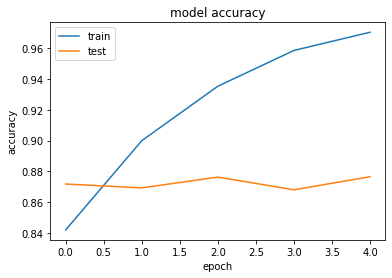

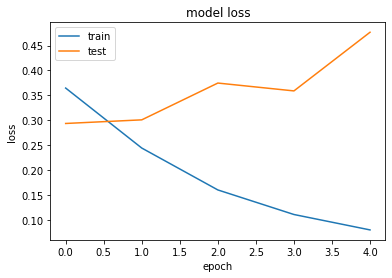

In [ ]:
#need to have more than 1 epoch to train
print(bert_history.history.keys())
print(bert_history)
# summarize history for accuracy
from matplotlib import pyplot as plt
plt.plot(bert_history.history['accuracy'])
plt.plot(bert_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(bert_history.history['loss'])
plt.plot(bert_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

myEpx_24K+8KFormalityClassifier <br>
Epoch 1: <br>
test_loss: 0.3717 - accuracy: 0.8311 <br>
10Ktest_loss: 0.3027 - accuracy: 0.8623 <br>
Epoch 2: <br>
test_loss: 0.2718 - accuracy: 0.8855 <br>
10Ktest_loss: 0.2450 - accuracy: 0.8950<br>
Epoch 3: <br>
test_loss: 0.3235 - accuracy: 0.8643<br>
10Ktest_loss:loss: 0.2682 - accuracy: 0.8891



<h1>Evaluate with Test </h1>

For Importing Models

In [ ]:
#import model
model=TFBertForSequenceClassification.from_pretrained('bert-base-uncased')
#paste the path to the saved weights
model.load_weights("#path to FomalityClassifierModelWeights")


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertForSequenceClassification: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['dropout_37', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
learning_rate = 2e-5

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

For Evaluating Models

In [ ]:
model.evaluate(ds_test_encoded)

417/417 [==============================] - 109s 262ms/step - loss: 0.2718 - accuracy: 0.8855


[0.27184635400772095, 0.8855084180831909]

In [ ]:
model.evaluate(ds_10Ktest_encoded)

1667/1667 [==============================] - 447s 268ms/step - loss: 0.2682 - accuracy: 0.8891


[0.26821017265319824, 0.8891000151634216]

Period less： 0.8655
Period： 0.8985

In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_189 (Dropout)        multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


<h1>Tryouts</h1>

In [11]:
!pip install -q transformers

In [5]:
import tensorflow as tf
from tensorflow import keras
from transformers import TFBertForSequenceClassification
from transformers import BertTokenizer

In [ ]:
tokenizer=BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [16]:
def getPrediction(sentence,thismodel):
  inputs=tokenizer(sentence,return_tensors="tf")
  outputs=thismodel(inputs,return_dict=True)
  #print(outputs)
  #print(outputs.loss)
  #print(outputs.logits)
  logits=outputs.logits
  probs = tf.nn.softmax(logits)
  prediction = tf.math.argmax(probs, axis=1)
  print(f"probs {probs}")
  print("prediction: 0 for informal; 1 for formal")
  print(f"prediction: {prediction}")

Please go to https://drive.google.com/drive/folders/1mDlYfLHuIiNA8kHZooXAqpk5eZBOj39o?usp=sharing to download the model weights </br>
and paste the path in the path_to_model_weight below

In [ ]:
path_to_model_weight=""
demo_model=TFBertForSequenceClassification.from_pretrained('bert-base-uncased')
demo_model.load_weights(path_to_model_weight)

In [20]:
#put your sentence in the input_sentence
input_sentence="I loveeee BERT lol."

In [21]:
getPrediction(input_sentence,demo_model)

probs [[0.9362825  0.06371745]]
prediction: 0 for informal; 1 for formal
prediction: [0]


<h1> Saving model weights <h2>

In [ ]:
model.save_weights("")

Insight: adding "." at the end of the sentence makes it too much more formal. Need to rethink about it